# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [11]:
df['text'][2]

'Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt like I was watching a junior high video presentation. Have the directors, producers, etc. ever even seen a movie before? Halestorm is getting worse and worse with every new entry. The concept for this movie sounded so funny. How could you go wrong with Gary Coleman and a handful of somewhat legitimate actors. But trust me when I say this, things went wrong, VERY WRONG.'

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [13]:
data.train_ds[0][0]

Text xxbos xxmaj it is difficult to evaluate this or any other comparable film of the early sound era in terms that one might use for ordinary film commentary . xxmaj at times there is almost a desperation , as many film personalities of the silent era try their wings at sound , surely xxunk that they will be left by the wayside ( as did happen to some ) , xxmaj xxunk - xxmaj tin - xxmaj tin . however , was xxunk natural . xxmaj in such a vaudeville of unrelated sequences , some were sure to stand out xxmaj john xxmaj barrymore 's xxunk from xxmaj richard xxup ii is a moment certainly worth xxunk . xxmaj by and large , only those with earlier stage training xxunk confidence . xxmaj however , this is over all reasonably entertaining , and a must for " film buffs " especially interested in the silent to sound transition

But the underlying data is all numbers

In [14]:
data.train_ds[0][0].data[:10]

array([   2,    5,   17,   16,  694,   15, 4731,   21,   56,  110])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [15]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [16]:
bs=48

Now let's grab the full dataset for what follows.

In [17]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup')]

In [18]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [30]:
pd

<module 'pandas' from '/opt/anaconda3/lib/python3.7/site-packages/pandas/__init__.py'>

In [32]:
teach = pd.read_csv('teach.txt', header=None)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 3, saw 8


In [51]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = collections.Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1

        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return token_id

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))
        self.num_tokens = len(self.dictionary)

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids
    
# https://github.com/fastai/fastai_docs/blob/master/dev_nb/007_wikitext_2.ipynb
# download data from https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
EOS = '<eos>'
PATH=Path('')

def read_file(filename):
    tokens = []
    with open(PATH/filename, encoding='utf8') as f:
        for line in f:
            tokens.append(line.split() + [EOS])
    return np.array(tokens)

In [57]:
train_tok = read_file('train.txt')
valid_tok = read_file('valid.txt')
test_tok = read_file('test.txt')

cor = Corpus('')
voc = Vocab(cor.dictionary.idx2word)

In [58]:
bs = 256
bptt = 35

In [59]:
dat = TextLMDataBunch.from_tokens('data', 
                                  trn_tok = train_tok, trn_lbls = None,
                                  val_tok = valid_tok, val_lbls=None,
                                  tst_tok = test_tok, 
                                  vocab = voc,
                                  bs = bs, bptt = bptt)

In [60]:
dat.show_batch()

idx,text
0,"world peace through the internal <eos> transformation of individuals is difficult, it is the only way. Wherever I go, I <eos> express this, and I am encouraged that people from many different walks of <eos>"
1,"the small acts of our daily lives, then shows us how to use the <eos> benefits of mindful-ness and concentration to transform and heal difficult <eos> psychological states. Finally he shows us the connection between"
2,"this poem: <eos> <eos> Peace is every step. <eos> <eos> The shining red sun is my heart. <eos> <eos> Each flower smiles with me. <eos> <eos> How green, how fresh all that grows. <eos> <eos>"
3,"Hanh in 1982 when he attended the Reverence for Life <eos> conference in New York. I was one of the first American Buddhists he had <eos> met, and it fascinated him that I looked,"
4,"years later, he <eos> co-founded what was to become the foremost center of Buddhist studies in <eos> South Vietnam, the An Quang Buddhist Institute. <eos> <eos> In 1961, Nhat Hanh came to the United States"


In [72]:
learn = language_model_learner(dat, AWD_LSTM, drop_mult=0.3)

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


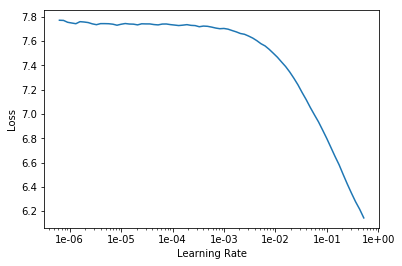

In [63]:
learn.recorder.plot(skip_end=15)

In [73]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.434243,6.291749,0.146763,00:02


In [78]:
TEXT = "How to breath"
N_WORDS = 40
N_SENTENCES = 2

In [79]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

How to breath Me a child parents work peacefully and your children will not be accept our York. We is very paper. I can sit back and walk every morning to see the baby and look at all your lives and you will
How to breath The mindful of the clinging to the peace, it? <eos> to have a very important Once <eos> many can help us picked up the us. It is very important to there, even if the They is really your happiness is


In [74]:
learn.unfreeze()

In [75]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.806639,6.036196,0.155804,00:03
1,6.583589,5.786737,0.167187,00:03
2,6.383882,5.573412,0.173661,00:03
3,6.185344,5.467985,0.168750,00:03
4,5.985403,5.375642,0.186272,00:03
5,5.787715,5.335625,0.188058,00:03
6,5.605351,5.299256,0.190513,00:03
7,5.440596,5.335407,0.185937,00:03
8,5.302589,5.332061,0.189397,00:03
9,5.186543,5.345100,0.188839,00:03


In [19]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [20]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [29]:
data_lm.show_batch()

idx,text
0,and violence and profanity shown in this film . xxbos xxmaj the reason why this movie is n't any better known and more appreciated to me seems because of its subject . xxmaj because of its controversial subject this movie never got a proper big release and still remains a fairly unknown one to this very day . xxmaj not that it 's subject is that controversial now anymore though
1,"the son of a xxmaj greek mafia gangster who wants the two relics returned to xxmaj greece by any means necessary & there 's also the small fact that a gigantic squid is guarding the precious bounty & basically kills anyone who goes near it . xxmaj can xxmaj nicole beat the odds , find the treasure & become famous or will she & her crew end up as squid"
2,"about this show is what they did to the villains . xxmaj they 've taken away everything that makes them likable and relatable and turned them into stereotypical evil bad guys . xxmaj man - xxmaj bat is the biggest example . xxmaj in the comics , he 's a tragic scientist who studies bats to find a cure for his deafness . xxmaj when experimenting on himself , he"
3,"none other than that bombshell comedienne herself , xxup joan xxup blondell . xxmaj just when you think she is only going to be a sidekick , she turns into xxup the kick . xxmaj her comic flair and range serve her well . \n \n xxmaj as do the talents of the xxmaj donald macbride as the xxmaj police xxmaj captain . ( xxmaj it 's amazing how"
4,"touching movies about xxmaj american history , here 's your chance to see how those in the xxmaj eastern block struggled and fought for their lives . xxmaj it 's totally different and i hope it 'll bring difference . \n \n xxmaj wanted to give a 10 , but -1 coz of xxup dk . xxbos xxmaj seriously xxmaj reality xxmaj charity xxup tv xxmaj these producers must"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.958489,3.885153,0.310139
2,3.871605,3.814774,0.319821
3,3.804589,3.767966,0.325793
4,3.771248,3.729666,0.330175
5,3.677534,3.699244,0.333532
6,3.644140,3.674071,0.336564
7,3.603597,3.655099,0.338747
8,3.524271,3.641979,0.340568
9,3.505476,3.636194,0.341246
10,3.461232,3.635963,0.341371


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');